<center> <h1> Diagnose Latent Cytomegalovirus Using CyTOF Data and Deep Learning <h1> </center>

<center>Zicheng Hu, Ph.D.</center>
<center>Research Scientist</center>
<center>ImmPort Team</center>
<center>The Unversity of California, San Francisco</center>

![alt text](Data/header.png)

In [1]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time

In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
phenotype = 'Expsample Treatement'

In [4]:
##### Step 2: load data #####

tutorial_files = ! ls Data
if "allData.obj" not in tutorial_files:
    print("Downloading Data:")
    ! wget https://ucsf.box.com/shared/static/tn8m9hco3f3gugn7z394yzimvtfdg129.obj -O ./Data/allData.obj
        
#load data
with open("FCS_to_Array/agingData.obj", "rb") as f:
    allData = pickle.load(f)
metaData = allData["samples"]
cytoData = allData['expr_list']
markerNames = allData["marker_names"]

print("Dimensions of cytoData: ",cytoData.shape,"\n")
print("Names of the makers: \n",markerNames.values)

Dimensions of cytoData:  (753, 20000, 13, 1) 

Names of the makers: 
 ['FSC-A' 'FSC-H' 'FSC-W' 'SSC-A' 'SSC-H' 'SSC-W' 'PSTAT1' 'PSTAT5' 'CD66B'
 'CD33' 'CD3/CD14' 'PSTAT3' 'CD4/CD19']


In [49]:
##### Step 3: split train, validation and test######
phenos = sorted(set(metaData[phenotype].values))
y = np.array([phenos.index(_) for _ in metaData[phenotype].values])
y = y.reshape(list(y.shape)+[1])
x = cytoData
pheno_map = dict(enumerate(phenos))

x_train, x_valid, y_train, y_valid = train_test_split(x, y)
# train_id = (metaData.study_accession.isin(["SDY515","SDY519"])==False)
# valid_id = metaData.study_accession=="SDY515"
# test_id = metaData.study_accession =="SDY519"

# x_train = x[train_id]; y_train = y[train_id]
# x_valid = x[valid_id]; y_valid = y[valid_id]
# x_test = x[test_id]; y_test = y[test_id]

In [50]:
list(metaData[phenotype].values) == [pheno_map[_[0]] for _ in y]

True

In [51]:
# ##### Step 4: define model #####

# # input
# model_input = Input(shape=x_train[0].shape)

# # first convolution layer
# model_output = Conv2D(3, kernel_size=(1, x_train.shape[2]),
#                  activation=None)(model_input)
# model_output = BatchNormalization()(model_output)
# model_output = Activation("relu")(model_output)

# # sceond convolution layer
# model_output = Conv2D(3, (1, 1), activation=None)(model_output)
# model_output = BatchNormalization()(model_output)
# model_output = Activation("relu")(model_output)

# # pooling layer
# model_output = AveragePooling2D(pool_size=(x_train.shape[1], 1))(model_output)
# model_output = Flatten()(model_output)

# # Dense layer
# model_output = Dense(3, activation=None)(model_output)
# model_output = BatchNormalization()(model_output)
# model_output = Activation("relu")(model_output)

# # output layer
# model_output = Dense(1, activation=None)(model_output)
# model_output = BatchNormalization()(model_output)
# model_output = Activation("sigmoid")(model_output)

# ##### Step 5: Fit model #####

# # specify input and output
# model = Model(inputs=[model_input],
#               outputs=model_output)

# # define loss function and optimizer
# model.compile(loss='binary_crossentropy',
#               optimizer=Adam(lr=0.0001),
#               metrics=['accuracy'])

# model.summary()

In [67]:
aging_model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(12, kernel_size = (1, x.shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
#     Conv2D(12, kernel_size = (1,1), activation=None),
#     BatchNormalization(),
#     Activation('relu'),
    AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
#     Dense(12, activation=None),
#     BatchNormalization(),
#     Activation('relu'),
    Dense(len(pheno_map), activation=None),
    BatchNormalization(),
    Activation('sigmoid'),
])
aging_model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
aging_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 20000, 1, 12)      168       
_________________________________________________________________
batch_normalization_24 (Batc (None, 20000, 1, 12)      48        
_________________________________________________________________
activation_36 (Activation)   (None, 20000, 1, 12)      0         
_________________________________________________________________
average_pooling2d_10 (Averag (None, 1, 1, 12)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 12)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 65        
_________________________________________________________________
batch_normalization_25 (Batc (None, 5)                

In [68]:
model = aging_model

# save the best performing model
checkpointer = ModelCheckpoint(filepath='Result/saved_weights.hdf5', 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=30, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/30
10/10 [==============================] - 1s 99ms/step - loss: 1.9698 - accuracy: 0.1770 - val_loss: 2.3824 - val_accuracy: 0.2275
Epoch 2/30
10/10 [==============================] - 1s 52ms/step - loss: 1.9042 - accuracy: 0.1930 - val_loss: 2.2446 - val_accuracy: 0.2275
Epoch 3/30
10/10 [==============================] - 1s 52ms/step - loss: 1.8599 - accuracy: 0.1887 - val_loss: 2.0700 - val_accuracy: 0.2275
Epoch 4/30
10/10 [==============================] - 1s 52ms/step - loss: 1.7463 - accuracy: 0.2224 - val_loss: 1.9690 - val_accuracy: 0.2169
Epoch 5/30
10/10 [==============================] - 1s 52ms/step - loss: 1.6981 - accuracy: 0.2406 - val_loss: 1.8915 - val_accuracy: 0.2063
Epoch 6/30
10/10 [==============================] - 1s 52ms/step - loss: 1.6389 - accuracy: 0.2375 - val_loss: 1.8226 - val_accuracy: 0.2328
Epoch 7/30
10/10 [==============================] - 1s 52ms/step - loss: 1.6588 - accuracy: 0.2256 - val_loss: 1.8085 - val_accuracy: 0.2116
Epoch 8/30
10

In [69]:
rt

16.999591827392578

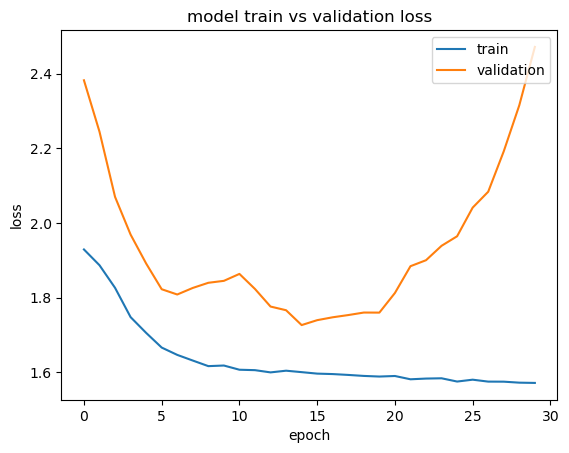

In [70]:
##### Step 6: plot train and validation loss #####
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

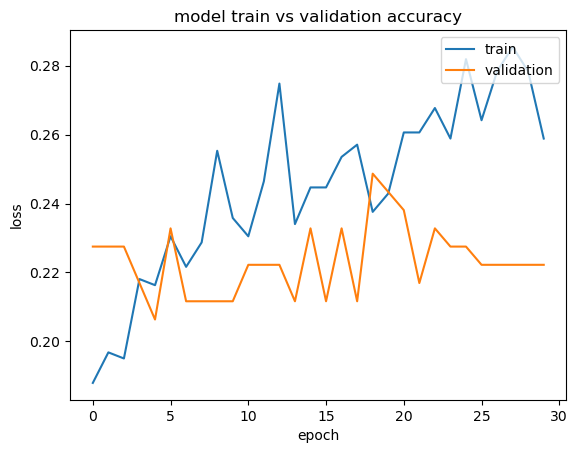

In [71]:
##### Step 6: plot train and validation accuracy #####
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
##### Step 7: test the final model #####

# # load final model
# # final_model = load_model('Data/Final_weights.hdf5')
# final_model = model
# x_test = x_valid
# y_test = y_valid

# # generate ROC and AUC
# y_scores = final_model.predict([x_test])

In [ ]:
# fpr, tpr, _ = roc_curve(y_test, y_scores)
# roc_auc = auc(fpr, tpr)

# # plot ROC curve
# plt.plot(fpr, tpr)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('AUC = {0:.2f}'.format(roc_auc))
# plt.show()